In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lazypredict

from sklearn import linear_model
from sklearn.linear_model import RANSACRegressor, HuberRegressor, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from lazypredict.Supervised import LazyClassifier, LazyRegressor

In [6]:
#sl = School Level
sl_2022 = pd.read_csv("../Datasets/sl_2022.csv")

#dl = District Level
dl_2022 = pd.read_csv("../Datasets/dl_2022.csv")

Quick Recap of the data as seen in the EDA:

Downloaded SL and CW reports as Excel files from https://www.cps.edu/about/district-data/metrics/

-Removed the Overview tab from both files.

-Removed footnotes from SL file as it created rows full of only NA values after saving as CSV.

-Removed top header and used subheaders as headers to avoid reading issues with loading into DF.

-After the above steps were taken, saved both files as a CSV with UTF-8 encoding.

-Note:  Superscripts get saved as normal numbers, i.e., test^2 would save as test2. Might go back and clean up or maybe leave as is.

-SL data types became object; had to astype relevent columns to int before creating visualizations.

-EOY:  Data from 7/1 to 6/30 of the respective year; includes S1 data.

-2 All CPS schools should document and track all misconducts that arise to the level of an Office Disciplinary Referral and are Student Code of Conduct infractions.

The # of Misconducts displayed here represents all Student Code of Conduct infractions that have been reported through IMPACT Verify each school year.

-3 Group 1-2 Example: Leaving class without permission

-4 Group 3-4 Example: Fighting

-5 Group 5-6 Example: Gang activity

-Schools are able to apply both an in school and out of school suspension to one misconduct event. In those cases, the suspension is only counted once.

-Misconduct and suspension data includes only district-managed schools; Expulsion data includes all district-managed and charter schools.

In [4]:
dl_2022.head()

,Category,School Year,Time Period1,# of Misconducts2,# of Group 1-2 (minor) Misconducts3,# of Group 3-4 (moderate) Misconducts4,# of Group 5-6 (major) Misconducts5,# of Suspensions6,% of Misconducts Resulting in a Suspension,# of ISS,...,Police Notifications per 100 Students,# of Unique Students Receiving Police Notification,% of Unique Students Receiving Police Notification,# of Students Expelled,Expulsions per 100 Students,# of Students Expelled.1,Expulsions per 100 Students.1,# of Students Expelled.2,Expulsions per 100 Students.2,Unnamed: 32
0,District Wide,2013-2014,S1,61661.00,31505.00,26153.00,4003.00,45455.00,73.70,20226.00,...,0.68,1864.00,0.60,205.00,0.06,70.00,0.02,135.00,0.28,NaN
1,District Wide,2013-2014,EOY,120543.00,58906.00,53311.00,8326.00,87763.00,72.80,38055.00,...,1.46,3543.00,1.20,495.00,0.17,184.00,0.06,311.00,0.79,NaN
2,District Wide,2014-2015,S1,60026.00,35577.00,20971.00,3478.00,27601.00,46.00,17675.00,...,0.61,1671.00,0.50,138.00,0.04,20.00,0.01,118.00,0.23,NaN
3,District Wide,2014-2015,EOY,132529.00,74771.00,49841.00,7917.00,63031.00,47.60,38668.00,...,1.42,3347.00,1.10,430.00,0.15,111.00,0.04,319.00,0.78,NaN
4,District Wide,2015-2016,S1,60093.00,34187.00,22244.00,3662.00,26924.00,44.80,16747.00,...,0.48,1340.00,0.40,138.00,0.04,34.00,0.01,104.00,0.20,NaN


In [5]:
dl_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 33 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Category                                            653 non-null    object 
 1   School Year                                         653 non-null    object 
 2   Time Period1                                        653 non-null    object 
 3   # of Misconducts2                                   653 non-null    float64
 4   # of Group 1-2 (minor) Misconducts3                 641 non-null    float64
 5   # of Group 3-4 (moderate) Misconducts4              637 non-null    float64
 6   # of Group 5-6 (major) Misconducts5                 574 non-null    float64
 7   # of Suspensions6                                   602 non-null    float64
 8   % of Misconducts Resulting in a Suspension          602 non-null    float64
 9  

In [6]:
DLML1322 = dl_2022.loc[(dl_2022['Time Period1'] == 'EOY')]

In [7]:
DLML1322.head()

,Category,School Year,Time Period1,# of Misconducts2,# of Group 1-2 (minor) Misconducts3,# of Group 3-4 (moderate) Misconducts4,# of Group 5-6 (major) Misconducts5,# of Suspensions6,% of Misconducts Resulting in a Suspension,# of ISS,...,Police Notifications per 100 Students,# of Unique Students Receiving Police Notification,% of Unique Students Receiving Police Notification,# of Students Expelled,Expulsions per 100 Students,# of Students Expelled.1,Expulsions per 100 Students.1,# of Students Expelled.2,Expulsions per 100 Students.2,Unnamed: 32
1,District Wide,2013-2014,EOY,120543.00,58906.00,53311.00,8326.00,87763.00,72.80,38055.00,...,1.46,3543.00,1.20,495.00,0.17,184.00,0.06,311.00,0.79,NaN
3,District Wide,2014-2015,EOY,132529.00,74771.00,49841.00,7917.00,63031.00,47.60,38668.00,...,1.42,3347.00,1.10,430.00,0.15,111.00,0.04,319.00,0.78,NaN
5,District Wide,2015-2016,EOY,122104.00,68376.00,46004.00,7724.00,57321.00,46.90,34174.00,...,1.16,2637.00,0.90,358.00,0.13,75.00,0.03,283.00,0.65,NaN
7,District Wide,2016-2017,EOY,100489.00,62078.00,32379.00,6032.00,38199.00,38.00,21574.00,...,0.97,2215.00,0.80,258.00,0.09,103.00,0.04,155.00,0.37,NaN
9,District Wide,2017-2018,EOY,97727.00,63453.00,28190.00,6084.00,34168.00,35.00,20605.00,...,1.02,1995.00,0.90,198.00,0.08,52.00,0.02,146.00,0.37,NaN


In [8]:
print(DLML1322.apply(lambda col: col.unique()))

Category                                              [District Wide, Male, Female, Non-Binary Gende...
School Year                                           [2013-2014, 2014-2015, 2015-2016, 2016-2017, 2...
Time Period1                                                                                      [EOY]
# of Misconducts2                                     [120543.0, 132529.0, 122104.0, 100489.0, 97727...
# of Group 1-2 (minor) Misconducts3                   [58906.0, 74771.0, 68376.0, 62078.0, 63453.0, ...
# of Group 3-4 (moderate) Misconducts4                [53311.0, 49841.0, 46004.0, 32379.0, 28190.0, ...
# of Group 5-6 (major) Misconducts5                   [8326.0, 7917.0, 7724.0, 6032.0, 6084.0, 7824....
# of Suspensions6                                     [87763.0, 63031.0, 57321.0, 38199.0, 34168.0, ...
% of Misconducts Resulting in a Suspension            [72.8, 47.6, 46.9, 38.0, 35.0, 42.5, 31.1, 1.1...
# of ISS                                              [38055.0, 

In [9]:
DLMLF1322 = DLML1322[['Category','School Year','# of Misconducts2','# of Group 1-2 (minor) Misconducts3','# of Group 3-4 (moderate) Misconducts4','# of Group 5-6 (major) Misconducts5',
    '# of Police Notifications', '% of Misconducts Resulting in Police Notification']]
DLMLF1322 = DLMLF1322.loc[((DLMLF1322['Category'] == 'Grade PK-2') | (DLMLF1322['Category'] == 'Grade 3-5') | (DLMLF1322['Category'] == 'Grade 6-8') | (DLMLF1322['Category'] == 'Grade 9-12'))]

In [10]:
DLMLF1322.head()

,Category,School Year,# of Misconducts2,# of Group 1-2 (minor) Misconducts3,# of Group 3-4 (moderate) Misconducts4,# of Group 5-6 (major) Misconducts5,# of Police Notifications,% of Misconducts Resulting in Police Notification
582,Grade PK-2,2013-2014,5014.00,2353.00,2413.00,248.00,33.00,0.70
584,Grade PK-2,2014-2015,6012.00,3731.00,2140.00,141.00,48.00,0.80
586,Grade PK-2,2015-2016,5450.00,3481.00,1819.00,150.00,43.00,0.80
588,Grade PK-2,2016-2017,4655.00,2887.00,1637.00,131.00,46.00,1.00
590,Grade PK-2,2017-2018,4703.00,3135.00,1470.00,98.00,47.00,1.00


In [11]:
print(DLMLF1322.apply(lambda col: col.unique()))

Category                                                [Grade PK-2, Grade 3-5, Grade 6-8, Grade 9-12]
School Year                                          [2013-2014, 2014-2015, 2015-2016, 2016-2017, 2...
# of Misconducts2                                    [5014.0, 6012.0, 5450.0, 4655.0, 4703.0, 4648....
# of Group 1-2 (minor) Misconducts3                  [2353.0, 3731.0, 3481.0, 2887.0, 3135.0, 3186....
# of Group 3-4 (moderate) Misconducts4               [2413.0, 2140.0, 1819.0, 1637.0, 1470.0, 1264....
# of Group 5-6 (major) Misconducts5                  [248.0, 141.0, 150.0, 131.0, 98.0, 198.0, 45.0...
# of Police Notifications                            [33.0, 48.0, 43.0, 46.0, 47.0, 26.0, 17.0, 1.0...
% of Misconducts Resulting in Police Notification    [0.7, 0.8, 1.0, 0.6, 0.3, 1.1, 0.9, 1.3, 1.2, ...
dtype: object


In [12]:
dt = ['Category','School Year','# of Misconducts2','# of Group 1-2 (minor) Misconducts3','# of Group 3-4 (moderate) Misconducts4','# of Group 5-6 (major) Misconducts5',
    '# of Police Notifications', '% of Misconducts Resulting in Police Notification']

for i in dt:
    print(np.dtype(DLMLF1322[i]))

object
object
float64
float64
float64
float64
float64
float64


In [13]:
DLMLF1322['Category'] = DLMLF1322['Category'].astype('category').cat.codes
DLMLF1322['School Year'] = DLMLF1322['School Year'].astype('category').cat.codes

In [14]:
print(np.dtype(DLMLF1322['Category']))
print(np.dtype(DLMLF1322['School Year']))

int8
int8


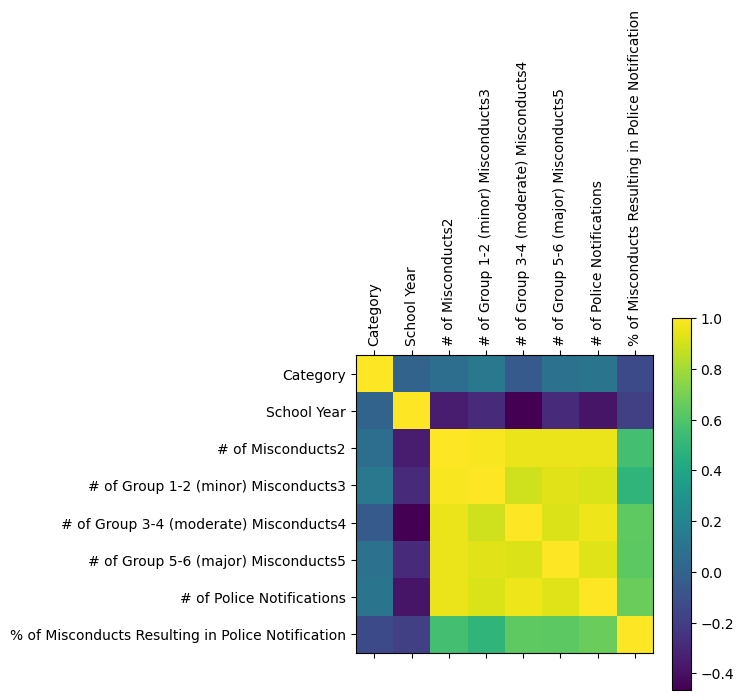

In [15]:
plt.matshow(DLMLF1322.corr())
plt.xticks(np.arange(8), DLMLF1322.columns, rotation=90)
plt.yticks(np.arange(8), DLMLF1322.columns, rotation=0)
plt.colorbar()
plt.show()

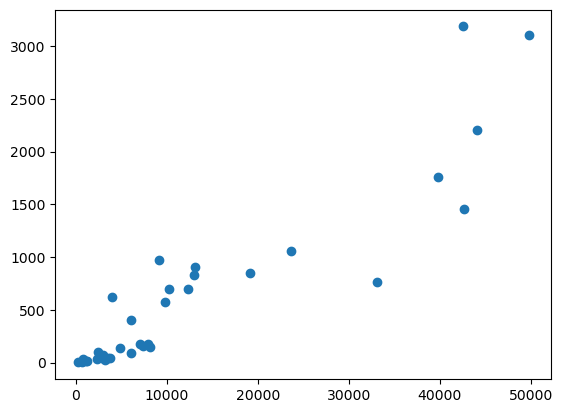

In [16]:
plt.scatter(DLMLF1322['# of Group 1-2 (minor) Misconducts3'], DLMLF1322['# of Police Notifications'])

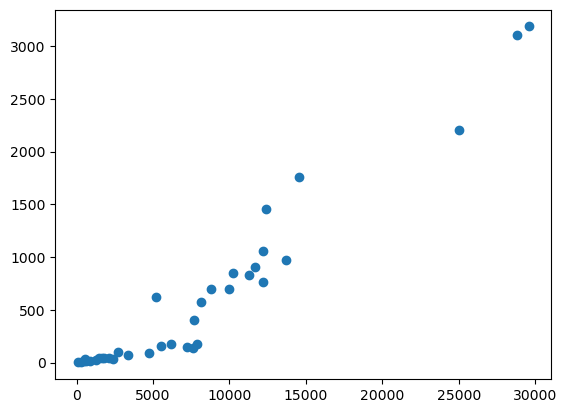

In [17]:
plt.scatter(DLMLF1322['# of Group 3-4 (moderate) Misconducts4'], DLMLF1322['# of Police Notifications'])

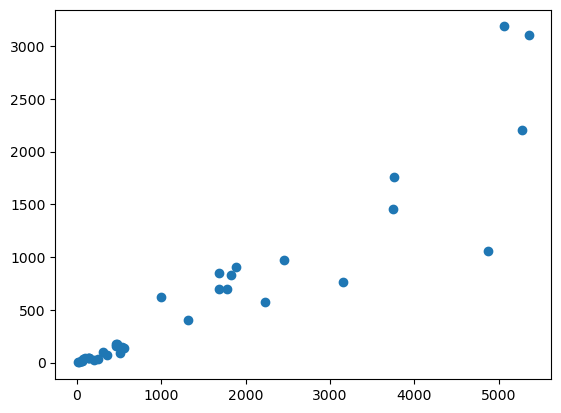

In [18]:
plt.scatter(DLMLF1322['# of Group 5-6 (major) Misconducts5'], DLMLF1322['# of Police Notifications'])

In [19]:
X = np.asarray(DLMLF1322[['# of Group 1-2 (minor) Misconducts3', '# of Group 3-4 (moderate) Misconducts4', '# of Group 5-6 (major) Misconducts5']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=123)

Score:  0.8540982793371228
Weights:  [[0.00872676 0.07219758 0.09436444]]


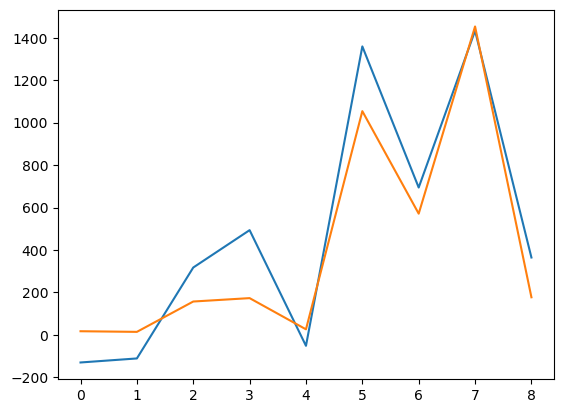

In [20]:
lineReg = LinearRegression()
lineReg.fit(X_train, y_train)
print('Score: ', lineReg.score(X_test, y_test))
print('Weights: ', lineReg.coef_)

plt.plot(lineReg.predict(X_test))
plt.plot(y_test)
plt.show()

Score:  0.8540982896253351
Weights:  [[0.00872676 0.07219758 0.09436442]]


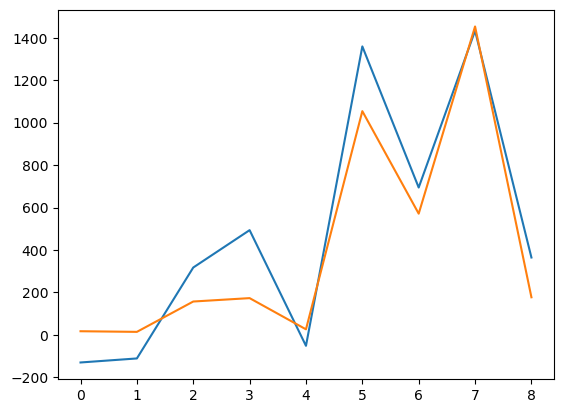

In [21]:
reg = linear_model.Ridge (alpha = .5)
reg.fit(X_train, y_train)
print('Score: ', reg.score(X_test, y_test))
print('Weights: ', reg.coef_)

plt.plot(reg.predict(X_test))
plt.plot(y_test)
plt.show()

In [22]:
# Using LazyClassifer to sort through various algorithms to find out which ones perform the best on these data.

X = np.asarray(DLMLF1322[['# of Group 1-2 (minor) Misconducts3', '# of Group 3-4 (moderate) Misconducts4', '# of Group 5-6 (major) Misconducts5']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=125)

#clf = LazyClassifier(verbose=0, ignore_warnings=False)
clf = LazyRegressor(verbose=0,ignore_warnings=False)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train, X_test, y_train, y_test)
models

100%|██████████| 42/42 [00:00<00:00, 66.04it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GammaRegressor,0.95,0.97,169.73,0.00
ExtraTreeRegressor,0.95,0.97,177.85,0.01
PoissonRegressor,0.95,0.97,180.89,0.01
OrthogonalMatchingPursuit,0.91,0.94,236.34,0.00
RANSACRegressor,0.90,0.94,249.04,0.01
OrthogonalMatchingPursuitCV,0.88,0.93,266.14,0.01
LassoLarsIC,0.88,0.93,267.05,0.01
LarsCV,0.88,0.93,267.05,0.01
Lars,0.88,0.93,267.05,0.01


In [23]:
model_dictionary

{'AdaBoostRegressor': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('numeric',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   Int64Index([0, 1, 2], dtype='int64')),
                                                  ('categorical_low',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(fill_value='missing',
                                                                                  strategy='constant')),
                                                                   ('encoding',
                       

In [24]:
# Taking a look at the school level data now.

sl_2022.head()

,School ID,School Name,School Network,School Year,Time Period,# of Misconducts,# of Group 1-2 Misconducts,# of Group 3-4 Misconducts,# of Group 5-6 Misconducts,# of Suspensions (includes ISS and OSS),...,# of Unique Students Receiving OSS,% of Unique Students Receiving OSS,Average Length of OSS,# of Police Notifications,% of Misconducts Resulting in a Police Notification,Police Notifications per 100 Students,# of Unique Students Receiving Police Notification,% of Unique Students Receiving Police Notification,# of Students Expelled,Expulsions per 100 Students
0,400121,ACERO - DE LA CRUZ,Charter,2017-2018,EOY,--,--,--,--,--,...,--,--,--,--,--,--,--,--,1,0.15
1,400081,ACERO - DE LAS CASAS,Charter,2018-2019,S1,--,--,--,--,--,...,--,--,--,--,--,--,--,--,1,0.38
2,400081,ACERO - DE LAS CASAS,Charter,2018-2019,EOY,--,--,--,--,--,...,--,--,--,--,--,--,--,--,1,0.38
3,400085,ACERO - GARCIA HS,Charter,2017-2018,EOY,--,--,--,--,--,...,--,--,--,--,--,--,--,--,2,0.33
4,400089,ACERO - MARQUEZ,Charter,2017-2018,S1,--,--,--,--,--,...,--,--,--,--,--,--,--,--,1,0.18


In [25]:
sl_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9220 entries, 0 to 9219
Data columns (total 30 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   School ID                                                          9220 non-null   int64  
 1   School Name                                                        9220 non-null   object 
 2   School Network                                                     9220 non-null   object 
 3   School Year                                                        9220 non-null   object 
 4   Time Period                                                        9220 non-null   object 
 5   # of Misconducts                                                   9220 non-null   object 
 6   # of Group 1-2 Misconducts                                         9220 non-null   object 
 7   # of Group 3-4 Misconduc

In [26]:
SLML1322 = sl_2022.loc[(sl_2022['Time Period'] == 'EOY')]

In [27]:
print(SLML1322.apply(lambda col: col.unique()))

School ID                                                             [400121, 400081, 400085, 400089, 400149, 60977...
School Name                                                           [ACERO - DE LA CRUZ, ACERO - DE LAS CASAS, ACE...
School Network                                                        [Charter, Network 13, ISP, Network 4, Military...
School Year                                                           [2017-2018, 2018-2019, 2019-2020, 2013-2014, 2...
Time Period                                                                                                       [EOY]
# of Misconducts                                                      [--, 12, 24, 19, 3, 16, 39, 25, 40, 63, 54, 66...
# of Group 1-2 Misconducts                                            [--, 1, 4, 2, 3, 8, 14, 16, 19, 23, 9, 38, 11,...
# of Group 3-4 Misconducts                                            [--, 9, 17, 12, 0, 27, 11, 18, 43, 35, 42, 37,...
# of Group 5-6 Misconducts              

In [28]:
SLMLF1322 = SLML1322[['School Name','School Network','School Year','# of Misconducts','# of Group 1-2 Misconducts','# of Group 3-4 Misconducts',
    '# of Group 5-6 Misconducts', '# of Suspensions (includes ISS and OSS)','# of Police Notifications', '% of Misconducts Resulting in a Police Notification']]

In [29]:
print(SLMLF1322.apply(lambda col: col.unique()))

School Name                                            [ACERO - DE LA CRUZ, ACERO - DE LAS CASAS, ACE...
School Network                                         [Charter, Network 13, ISP, Network 4, Military...
School Year                                            [2017-2018, 2018-2019, 2019-2020, 2013-2014, 2...
# of Misconducts                                       [--, 12, 24, 19, 3, 16, 39, 25, 40, 63, 54, 66...
# of Group 1-2 Misconducts                             [--, 1, 4, 2, 3, 8, 14, 16, 19, 23, 9, 38, 11,...
# of Group 3-4 Misconducts                             [--, 9, 17, 12, 0, 27, 11, 18, 43, 35, 42, 37,...
# of Group 5-6 Misconducts                             [--, 2, 3, 1, 4, 0, 6, 5, 27, 21, 22, 25, 15, ...
# of Suspensions (includes ISS and OSS)                [--, 10, 8, 15, 2, 22, 6, 16, 42, 24, 49, 53, ...
# of Police Notifications                              [--, 0, 2, 3, 1, 6, 5, 9, 15, 23, 4, 19, 8, 7,...
% of Misconducts Resulting in a Police Notification    

In [30]:
dt = ['School Name','School Network','School Year','# of Misconducts','# of Group 1-2 Misconducts','# of Group 3-4 Misconducts',
    '# of Group 5-6 Misconducts', '# of Suspensions (includes ISS and OSS)','# of Police Notifications', '% of Misconducts Resulting in a Police Notification']

for i in dt:
    print(np.dtype(SLMLF1322[i]))

object
object
object
object
object
object
object
object
object
object


In [31]:
SLMLF1322 = SLMLF1322[SLMLF1322['School Name'] != '--']
SLMLF1322 = SLMLF1322[SLMLF1322['School Network'] != '--']
SLMLF1322 = SLMLF1322[SLMLF1322['School Year'] != '--']

SLMLF1322 = SLMLF1322[SLMLF1322['# of Misconducts'] != '--']
SLMLF1322 = SLMLF1322[SLMLF1322['# of Group 1-2 Misconducts'] != '--']
SLMLF1322 = SLMLF1322[SLMLF1322['# of Group 3-4 Misconducts'] != '--']
SLMLF1322 = SLMLF1322[SLMLF1322['# of Group 5-6 Misconducts'] != '--']
SLMLF1322 = SLMLF1322[SLMLF1322['# of Suspensions (includes ISS and OSS)'] != '--']
SLMLF1322 = SLMLF1322[SLMLF1322['# of Police Notifications'].astype('int64') != '--']
SLMLF1322 = SLMLF1322[SLMLF1322['% of Misconducts Resulting in a Police Notification'] != '--']

In [32]:
SLMLF1322['School Name'] = SLMLF1322['School Name'].astype('category').cat.codes
SLMLF1322['School Network'] = SLMLF1322['School Network'].astype('category').cat.codes
SLMLF1322['School Year'] = SLMLF1322['School Year'].astype('category').cat.codes

SLMLF1322['# of Misconducts'] = SLMLF1322['# of Misconducts'].astype('int64')
SLMLF1322['# of Group 1-2 Misconducts'] = SLMLF1322['# of Group 1-2 Misconducts'].astype('int64')
SLMLF1322['# of Group 3-4 Misconducts'] = SLMLF1322['# of Group 3-4 Misconducts'].astype('int64')
SLMLF1322['# of Group 5-6 Misconducts'] = SLMLF1322['# of Group 5-6 Misconducts'].astype('int64')
SLMLF1322['# of Suspensions (includes ISS and OSS)'] = SLMLF1322['# of Suspensions (includes ISS and OSS)'].astype('int64')
SLMLF1322['# of Police Notifications'] = SLMLF1322['# of Police Notifications'].astype('int64')
SLMLF1322['% of Misconducts Resulting in a Police Notification'] = SLMLF1322['% of Misconducts Resulting in a Police Notification'].astype('float')

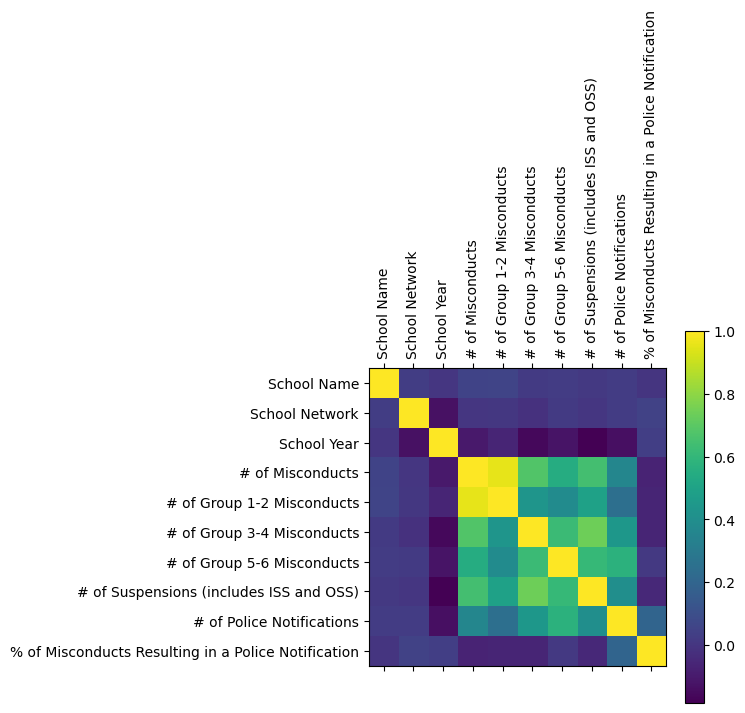

In [33]:
plt.matshow(SLMLF1322.corr())
plt.xticks(np.arange(10), SLMLF1322.columns, rotation=90)
plt.yticks(np.arange(10), SLMLF1322.columns, rotation=0)
plt.colorbar()
plt.show()

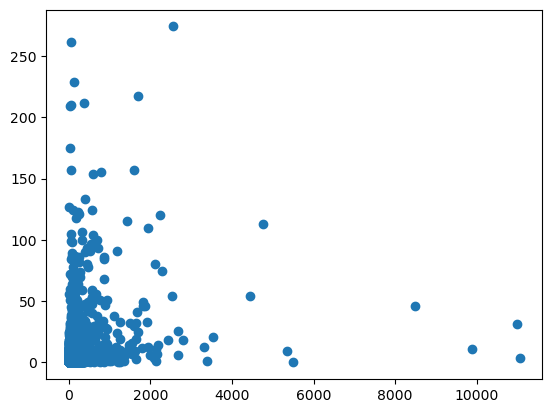

In [34]:
plt.scatter(SLMLF1322['# of Group 1-2 Misconducts'], SLMLF1322['# of Police Notifications'])

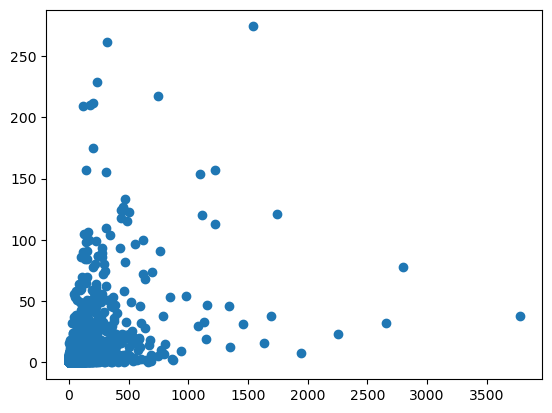

In [35]:
plt.scatter(SLMLF1322['# of Group 3-4 Misconducts'], SLMLF1322['# of Police Notifications'])

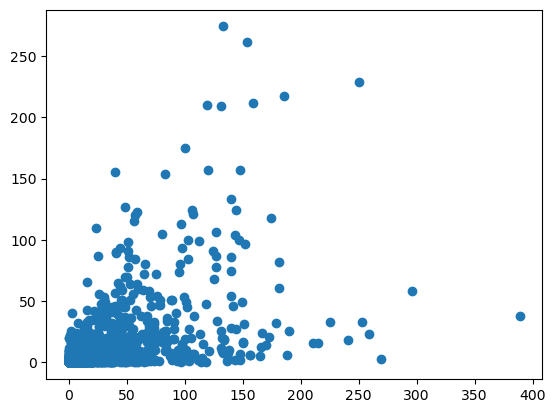

In [36]:
plt.scatter(SLMLF1322['# of Group 5-6 Misconducts'], SLMLF1322['# of Police Notifications'])

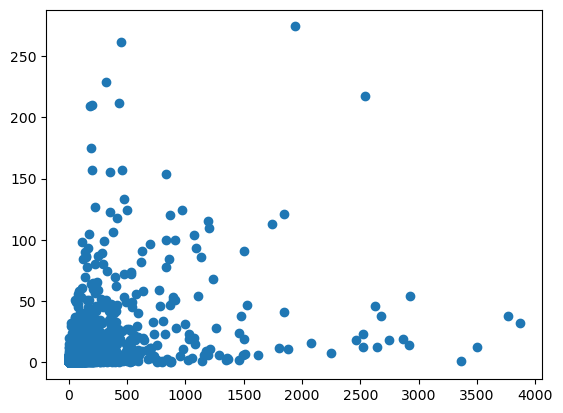

In [37]:
plt.scatter(SLMLF1322['# of Suspensions (includes ISS and OSS)'], SLMLF1322['# of Police Notifications'])

In [38]:
X = np.asarray(SLMLF1322[['# of Group 1-2 Misconducts', '# of Group 3-4 Misconducts', '# of Group 5-6 Misconducts']])
Y = np.asarray(SLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=123)

Score:  0.18690970933686302
Weights:  [[-0.00102305  0.01396318  0.34477901]]


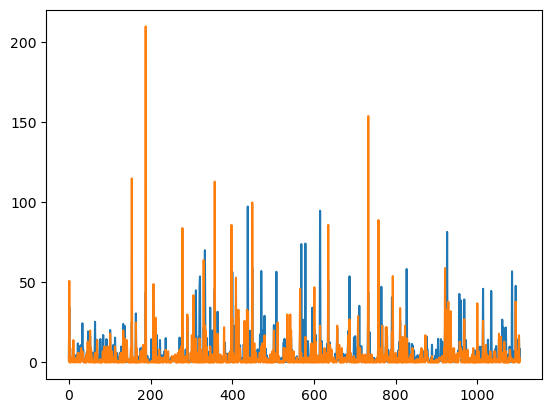

In [39]:
lineReg = LinearRegression()
lineReg.fit(X_train, y_train)
print('Score: ', lineReg.score(X_test, y_test))
print('Weights: ', lineReg.coef_)

plt.plot(lineReg.predict(X_test))
plt.plot(y_test)
plt.show()

Score:  0.18690981781881066
Weights:  [[-0.00102305  0.01396319  0.34477888]]


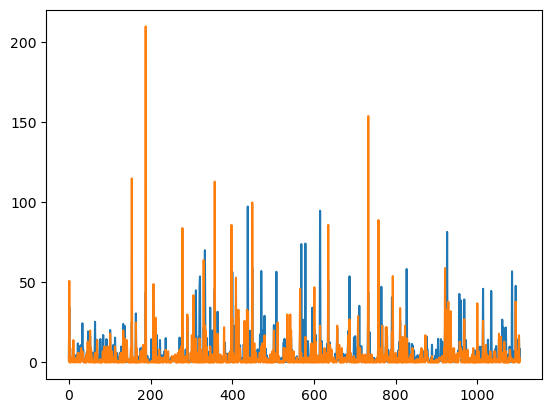

In [40]:
reg = linear_model.Ridge (alpha = .5)
reg.fit(X_train, y_train)
print('Score: ', reg.score(X_test, y_test))
print('Weights: ', reg.coef_)

plt.plot(reg.predict(X_test))
plt.plot(y_test)
plt.show()

In [77]:
# Using LazyClassifer to sort through various algorithms to find out which ones perform the best on these data.

X = np.asarray(SLMLF1322[['# of Group 1-2 Misconducts', '# of Group 3-4 Misconducts', '# of Group 5-6 Misconducts']])
Y = np.asarray(SLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=123)

#clf2 = LazyClassifier(verbose=0,ignore_warnings=False)
clf2 = LazyRegressor(verbose=0,ignore_warnings=False)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train, X_test, y_train, y_test)
models

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 21%|██▏       | 9/42 [00:00<00:02, 16.04it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


100%|██████████| 42/42 [07:38<00:00, 10.92s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
TweedieRegressor,0.28,0.28,10.85,0.01
ElasticNet,0.27,0.28,10.87,0.01
LinearSVR,0.26,0.26,10.96,0.02
HuberRegressor,0.26,0.26,10.96,0.02
NuSVR,0.24,0.24,11.13,0.73
SVR,0.23,0.23,11.18,0.78
Lasso,0.22,0.23,11.23,0.00
SGDRegressor,0.22,0.22,11.28,0.01
ElasticNetCV,0.21,0.22,11.30,0.05


In [ ]:
model_dictionary

{'AdaBoostRegressor': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('numeric',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   Int64Index([0, 1, 2], dtype='int64')),
                                                  ('categorical_low',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(fill_value='missing',
                                                                                  strategy='constant')),
                                                                   ('encoding',
                       

The correlations within the district level data seem to be more appealing than the school level data when comparing the categories of misconducts with the number of police notifications, so the focus from here will be on the district level data--especially as none of the algorithms seemed to perform too well on the school level data.

The three categories (i.e., Group 1-2, Group 3-4, Group5-6) will be looked at individually before exploring them together against the number of police notifications.

In [44]:
X = np.asarray(DLMLF1322[['# of Group 1-2 (minor) Misconducts3']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=125)

#clf = LazyClassifier(verbose=0, ignore_warnings=False)
clf = LazyRegressor(verbose=0,ignore_warnings=False)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train, X_test, y_train, y_test)
models

100%|██████████| 42/42 [00:00<00:00, 61.92it/s]

OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(27, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,0.80,0.82,413.40,0.01
HuberRegressor,0.78,0.81,428.94,0.01
SGDRegressor,0.78,0.80,433.72,0.00
LinearRegression,0.78,0.80,433.82,0.00
TransformedTargetRegressor,0.78,0.80,433.82,0.00
Lars,0.78,0.80,433.82,0.01
LassoLarsIC,0.78,0.80,433.82,0.01
LassoLarsCV,0.78,0.80,433.82,0.01
LarsCV,0.78,0.80,433.82,0.01


In [ ]:
X = np.asarray(DLMLF1322[['# of Group 3-4 (moderate) Misconducts4']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=125)

#clf = LazyClassifier(verbose=0, ignore_warnings=False)
clf = LazyRegressor(verbose=0,ignore_warnings=False)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train, X_test, y_train, y_test)
models

100%|██████████| 42/42 [00:00<00:00, 72.88it/s]

OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(27, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.97,0.97,157.80,0.02
XGBRegressor,0.97,0.97,157.93,0.03
DecisionTreeRegressor,0.97,0.97,157.94,0.00
ExtraTreeRegressor,0.97,0.97,158.11,0.01
ExtraTreesRegressor,0.97,0.97,166.18,0.05
AdaBoostRegressor,0.97,0.97,170.60,0.05
BaggingRegressor,0.96,0.96,185.68,0.02
RandomForestRegressor,0.95,0.95,214.95,0.07
SGDRegressor,0.93,0.94,236.34,0.01


In [ ]:
X = np.asarray(DLMLF1322[['# of Group 5-6 (major) Misconducts5']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=125)

#clf = LazyClassifier(verbose=0, ignore_warnings=False)
clf = LazyRegressor(verbose=0,ignore_warnings=False)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train, X_test, y_train, y_test)
models

100%|██████████| 42/42 [00:00<00:00, 72.19it/s]

OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(27, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
PoissonRegressor,0.88,0.90,313.77,0.01
HuberRegressor,0.83,0.85,376.16,0.01
SGDRegressor,0.82,0.84,388.13,0.01
Lars,0.82,0.84,388.27,0.00
LarsCV,0.82,0.84,388.27,0.01
LassoLarsIC,0.82,0.84,388.27,0.00
LassoLarsCV,0.82,0.84,388.27,0.01
OrthogonalMatchingPursuit,0.82,0.84,388.27,0.00
LinearRegression,0.82,0.84,388.27,0.00


RANSACRegressor, GradientBoostingRegressor, HuberRegressor (I have a personal vendetta against Poisson) seem to be the best model for each of the group pairings.

Going to run each category (1-2, 3-4, 5-6) through each of the three models.

In [49]:
X = np.asarray(DLMLF1322[['# of Group 1-2 (minor) Misconducts3']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

rans = RANSACRegressor()

rans.fit(X_train, y_train)
score_train = rans.score(X_train, y_train)
score_test = rans.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(rans, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = rans.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.8474055664697491
Test score:  0.8223091843348483
Mean cross-val score: 0.68
MSE:  170901.00
RMSE: 413.40


In [58]:
X = np.asarray(DLMLF1322[['# of Group 3-4 (moderate) Misconducts4']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

rans = RANSACRegressor()

rans.fit(X_train, y_train)
score_train = rans.score(X_train, y_train)
score_test = rans.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(rans, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = rans.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.8849195329465975
Test score:  0.9069590928700115
Mean cross-val score: 0.54
MSE:  89485.69
RMSE: 299.14


In [50]:
X = np.asarray(DLMLF1322[['# of Group 5-6 (major) Misconducts5']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

rans = RANSACRegressor()

rans.fit(X_train, y_train)
score_train = rans.score(X_train, y_train)
score_test = rans.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(rans, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = rans.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.8306925415158558
Test score:  0.9000476745774348
Mean cross-val score: 0.74
MSE:  96133.01
RMSE: 310.05


In [60]:
X = np.asarray(DLMLF1322[['# of Group 1-2 (minor) Misconducts3']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

reg = GradientBoostingRegressor()

reg.fit(X_train, y_train)
score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(reg, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.9998752017158207
Test score:  0.6167023374478704
Mean cross-val score: 0.78
MSE:  368651.33
RMSE: 607.17


In [51]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X = np.asarray(DLMLF1322[['# of Group 3-4 (moderate) Misconducts4']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

reg = GradientBoostingRegressor()

reg.fit(X_train, y_train)
score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(reg, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.999975011089302
Test score:  0.9741098892089175
Mean cross-val score: 0.60
MSE:  24900.81
RMSE: 157.80


In [57]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X = np.asarray(DLMLF1322[['# of Group 5-6 (major) Misconducts5']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

reg = GradientBoostingRegressor()

reg.fit(X_train, y_train)
score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(reg, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.9999349341709531
Test score:  0.4711515951543863
Mean cross-val score: 0.63
MSE:  508640.38
RMSE: 713.19


In [52]:
X = np.asarray(DLMLF1322[['# of Group 1-2 (minor) Misconducts3']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

hub = HuberRegressor()

hub.fit(X_train, y_train)
score_train = hub.score(X_train, y_train)
score_test = hub.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(hub, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = hub.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.845631971136748
Test score:  0.7762370287398639
Mean cross-val score: 0.72
MSE:  215212.68
RMSE: 463.91


In [59]:
X = np.asarray(DLMLF1322[['# of Group 3-4 (moderate) Misconducts4']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

hub = HuberRegressor()

hub.fit(X_train, y_train)
score_train = hub.score(X_train, y_train)
score_test = hub.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(hub, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = hub.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.9037126466280311
Test score:  0.9292196692539477
Mean cross-val score: 0.85
MSE:  68075.72
RMSE: 260.91


In [53]:
X = np.asarray(DLMLF1322[['# of Group 5-6 (major) Misconducts5']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

hub = HuberRegressor()

hub.fit(X_train, y_train)
score_train = hub.score(X_train, y_train)
score_test = hub.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(hub, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = hub.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.8504885374232546
Test score:  0.8530517993531285
Mean cross-val score: 0.80
MSE:  141333.11
RMSE: 375.94


The GradientBoostingRegressor focusing on Group 3-4 has a suboptimal mean cv score, but otherwise seems to perform better than the other combinations. Interestingly enough, the moderate level misconducts seem to predict the number of police notifications the best.

Going to focus on that particular combination and try to tune various parameters in an effort to better fit the model using values above and below the default values for the GBR model.

In [62]:
X = np.asarray(DLMLF1322[['# of Group 3-4 (moderate) Misconducts4']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

In [78]:
# Tuning n_estimators (default of 100) and learning rate (default of 0.1)

p_test = {'learning_rate':[0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.005, 0.001], 'n_estimators':[2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 100, 115, 125, 135, 145]}

tuning_ne_lr = GridSearchCV(estimator=GradientBoostingRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10),
    param_grid = p_test, scoring='r2', n_jobs=4, cv=5)

tuning_ne_lr.fit(X_train, y_train)
tuning_ne_lr.cv_results_, tuning_ne_lr.best_params_, tuning_ne_lr.best_score_

({'mean_fit_time': array([0.00400043, 0.00513926, 0.00576982, 0.00659556, 0.01195445,
         0.01690574, 0.02320585, 0.02447634, 0.0304019 , 0.03112278,
         0.03832407, 0.0434629 , 0.05032263, 0.05414391, 0.09609694,
         0.11733141, 0.12584901, 0.14718151, 0.14789701, 0.00340238,
         0.0054677 , 0.00573831, 0.00634422, 0.01063886, 0.01440716,
         0.01848769, 0.0229301 , 0.0256237 , 0.03327293, 0.03555784,
         0.04072652, 0.04791331, 0.05361938, 0.09120378, 0.11051049,
         0.11541014, 0.12931228, 0.14003935, 0.00297732, 0.00362992,
         0.00593886, 0.00615368, 0.01062274, 0.01538792, 0.02042665,
         0.02517676, 0.02707667, 0.03886242, 0.04315228, 0.04788775,
         0.04555387, 0.05491152, 0.09280381, 0.10478563, 0.11605268,
         0.12918453, 0.13303189, 0.00300159, 0.00310483, 0.00513844,
         0.00626912, 0.01142244, 0.01568198, 0.01827412, 0.02325425,
         0.03029037, 0.03523984, 0.03865342, 0.04185705, 0.04672456,
         0.056832

In [ ]:
# Tuning max_depth (default 3)

p_test2 = {'max_depth':[1,2,3,4,5,6,7,8,9]}

tuning_ne_lr = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.25, n_estimators=5, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10),
    param_grid = p_test2, scoring='r2', n_jobs=4, cv=5)

tuning_ne_lr.fit(X_train, y_train)
tuning_ne_lr.cv_results_, tuning_ne_lr.best_params_, tuning_ne_lr.best_score_

({'mean_fit_time': array([0.00201302, 0.00176992, 0.00202465, 0.00265403, 0.00236082,
         0.00665636, 0.00636311, 0.00301371, 0.00279603]),
  'std_fit_time': array([0.00062552, 0.00065065, 0.00041545, 0.00099088, 0.00052559,
         0.00852237, 0.00650607, 0.00177713, 0.00029486]),
  'mean_score_time': array([0.00050898, 0.00060158, 0.00029988, 0.00032125, 0.00050192,
         0.00084615, 0.00040302, 0.00184717, 0.00060258]),
  'std_score_time': array([0.00045701, 0.0004912 , 0.00039951, 0.00041505, 0.00044746,
         0.00020099, 0.00037802, 0.00169273, 0.00058445]),
  'param_max_depth': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 1},
   {'max_depth': 2},
   {'max_depth': 3},
   {'max_depth': 4},
   {'max_depth': 5},
   {'max_depth': 6},
   {'max_depth': 7},
   {'max_depth': 8},
   {'max_dep

In [ ]:
# Tuning min sample split (default 2) and leaf (default 1)

p_test3 = {'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20], 'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

tuning_mssl = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.25, n_estimators=5, max_depth=3, subsample=1, max_features='sqrt', random_state=10),
    param_grid = p_test3, scoring='r2', n_jobs=4, cv=5)

tuning_mssl.fit(X_train, y_train)
tuning_mssl.cv_results_, tuning_mssl.best_params_, tuning_mssl.best_score_

({'mean_fit_time': array([0.0025434 , 0.00228682, 0.00223565, 0.00220165, 0.00264158,
         0.002105  , 0.0017993 , 0.00192084, 0.00155153, 0.00158596,
         0.00180898, 0.00181932, 0.00168638, 0.00210042, 0.00210347,
         0.00211105, 0.00209961, 0.0020339 , 0.00166287, 0.00120134,
         0.00139556, 0.00191088, 0.00186687, 0.00207901, 0.00215688,
         0.00264997, 0.00187459, 0.00185142, 0.00200448, 0.00270824,
         0.0022397 , 0.00206041, 0.00218177, 0.0015491 , 0.00180154,
         0.00171318, 0.00121322, 0.00151615, 0.00121379, 0.00210123,
         0.00198464, 0.00200529, 0.00174894, 0.00229387, 0.00183744,
         0.00215101, 0.00186377, 0.00146275, 0.00175447, 0.00103374,
         0.00174093, 0.00175033, 0.00139899, 0.00180693, 0.00139952,
         0.00189071, 0.00193467, 0.00162177, 0.00216794, 0.00215664,
         0.00221004, 0.00140266, 0.00159984, 0.0023253 , 0.00155869,
         0.00099874, 0.0021904 , 0.00161281, 0.00197577, 0.00198636,
         0.001653

In [ ]:
# Tuning max features

p_test4 = {'max_features':['auto', 'sqrt', 'log2']}

tuning_mf = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.25, n_estimators=5, max_depth=3, min_samples_split=2, min_samples_leaf=2, subsample=1, random_state=10),
    param_grid = p_test4, scoring='r2', n_jobs=4, cv=5)

tuning_mf.fit(X_train, y_train)
tuning_mf.cv_results_, tuning_mf.best_params_, tuning_mf.best_score_

({'mean_fit_time': array([0.00210772, 0.00222325, 0.00216818]),
  'std_fit_time': array([0.0002216 , 0.00037313, 0.00043222]),
  'mean_score_time': array([0.00045009, 0.00051222, 0.00034685]),
  'std_score_time': array([0.00040762, 0.00046155, 0.00043335]),
  'param_max_features': masked_array(data=['auto', 'sqrt', 'log2'],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 'auto'},
   {'max_features': 'sqrt'},
   {'max_features': 'log2'}],
  'split0_test_score': array([0.95338933, 0.95754088, 0.95754088]),
  'split1_test_score': array([0.76710445, 0.92558569, 0.92558569]),
  'split2_test_score': array([0.84282024, 0.80515516, 0.80515516]),
  'split3_test_score': array([0.64877095, 0.66405283, 0.66405283]),
  'split4_test_score': array([0.96604431, 0.96176326, 0.96176326]),
  'mean_test_score': array([0.83562586, 0.86281957, 0.86281957]),
  'std_test_score': array([0.11877618, 0.11448578, 0.11448578]),
  'rank_

In [ ]:
# Tuning subsamples (default 0.1)

p_test5 = {'subsample':[0.01, 0.05, 0.15, 0.25, 0.45, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]}

tuning_ss = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.25, n_estimators=5, max_depth=3, min_samples_split=2, min_samples_leaf=2, max_features='auto', random_state=10),
    param_grid = p_test5, scoring='r2', n_jobs=4, cv=5)

tuning_ss.fit(X_train, y_train)
tuning_ss.cv_results_, tuning_ss.best_params_, tuning_ss.best_score_

({'mean_fit_time': array([0.00265856, 0.00271082, 0.00269589, 0.00260744, 0.00247149,
         0.00227122, 0.00292668, 0.00290375, 0.00267286, 0.00291891,
         0.00231323, 0.00285759, 0.0020318 ]),
  'std_fit_time': array([0.00063239, 0.00049116, 0.00028537, 0.00020065, 0.00062003,
         0.00108819, 0.00033352, 0.00056769, 0.00058389, 0.00024413,
         0.00036932, 0.00078496, 0.00057811]),
  'mean_score_time': array([0.00038238, 0.00041108, 0.00040002, 0.00034938, 0.00050683,
         0.00059915, 0.0004992 , 0.00012603, 0.00070157, 0.00010014,
         0.00075755, 0.00060458, 0.00061998]),
  'std_score_time': array([0.00047366, 0.00040509, 0.00020004, 0.00025024, 0.00045504,
         0.0004892 , 0.00044628, 0.00020449, 0.00040101, 0.00020027,
         0.00039223, 0.00049367, 0.00050757]),
  'param_subsample': masked_array(data=[0.01, 0.05, 0.15, 0.25, 0.45, 0.5, 0.7, 0.75, 0.8,
                     0.85, 0.9, 0.95, 1],
               mask=[False, False, False, False, False, F

In [54]:
# Running the tuned model.

X = np.asarray(DLMLF1322[['# of Group 3-4 (moderate) Misconducts4']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state=125)

reg = GradientBoostingRegressor(learning_rate=0.25, n_estimators=5, max_depth=3, min_samples_split=2, min_samples_leaf=2, max_features='auto', subsample=0.95, random_state=10)

reg.fit(X_train, y_train)
score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(reg, X_train, y_train, cv = 5)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.9007996343886897
Test score:  0.835131979777407
Mean cross-val score: 0.74
MSE:  158568.19
RMSE: 398.21


Base Model:  Train score:  0.999975011089302, Test score:  0.9741098892089175, Mean cross-val score: 0.60, MSE:  24900.81, RMSE: 157.80

Looks as though the tuned model is overfitting and the base model is offering a better overall fit--a test score of 0.974 is sufficiently good.

Using a similar process, the model that includes each of the three groups against the number of police notifications will be tuned.

In [55]:
# Base model

X = np.asarray(DLMLF1322[['# of Group 1-2 (minor) Misconducts3', '# of Group 3-4 (moderate) Misconducts4', '# of Group 5-6 (major) Misconducts5']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=125)

reg = GradientBoostingRegressor()

reg.fit(X_train, y_train)
score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(reg, X_train, y_train, cv = 7)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.999998513853411
Test score:  0.8773939387095198
Mean cross-val score: 0.85
MSE:  117921.11
RMSE: 343.40


In [65]:
# Tuning n_estimators (default of 100) and learning rate (default of 0.1)

p_test = {'learning_rate':[0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.005, 0.001], 'n_estimators':[2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 100, 115, 125, 135, 145]}

tuning_ne_lr = GridSearchCV(estimator=GradientBoostingRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10),
    param_grid = p_test, scoring='r2', n_jobs=4, cv=7)

tuning_ne_lr.fit(X_train, y_train)
tuning_ne_lr.cv_results_, tuning_ne_lr.best_params_, tuning_ne_lr.best_score_

({'mean_fit_time': array([0.00200173, 0.00231668, 0.00239948, 0.00285707, 0.00275196,
         0.0044632 , 0.00548441, 0.0073669 , 0.007289  , 0.0082844 ,
         0.00861628, 0.00968841, 0.00982063, 0.01219647, 0.01882972,
         0.02507179, 0.02493324, 0.02491338, 0.02774913, 0.00123   ,
         0.00144523, 0.00258902, 0.00174042, 0.00331102, 0.00327366,
         0.00434715, 0.00667933, 0.00779796, 0.00906774, 0.01031971,
         0.01108922, 0.0127652 , 0.01545862, 0.02368389, 0.02277432,
         0.02652485, 0.02656954, 0.02842546, 0.0015939 , 0.00217608,
         0.00223306, 0.00220081, 0.00262901, 0.00302158, 0.00495328,
         0.00621813, 0.00681189, 0.00761577, 0.0071983 , 0.00842285,
         0.01043466, 0.012995  , 0.01842359, 0.02390395, 0.02650326,
         0.02408733, 0.02682815, 0.00129202, 0.00165735, 0.00128722,
         0.00201161, 0.00257441, 0.00343459, 0.00501404, 0.00597477,
         0.00660001, 0.00709043, 0.00740147, 0.00979355, 0.01030718,
         0.010823

In [ ]:
# Tuning max_depth (default 3)

p_test2 = {'max_depth':[1,2,3,4,5,6,7,8,9]}

tuning_ne_lr = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.05, n_estimators=100, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10),
    param_grid = p_test2, scoring='r2', n_jobs=4, cv=7)

tuning_ne_lr.fit(X_train, y_train)
tuning_ne_lr.cv_results_, tuning_ne_lr.best_params_, tuning_ne_lr.best_score_

({'mean_fit_time': array([0.01780554, 0.0214809 , 0.02007457, 0.01982634, 0.02040424,
         0.0205791 , 0.02134933, 0.01894055, 0.01833262]),
  'std_fit_time': array([0.00155906, 0.00193922, 0.00320108, 0.00359914, 0.00132189,
         0.0017118 , 0.00188268, 0.00210582, 0.00245335]),
  'mean_score_time': array([0.00028678, 0.00066621, 0.00075327, 0.00057524, 0.0005734 ,
         0.00028855, 0.00057166, 0.0006472 , 0.0007234 ]),
  'std_score_time': array([0.00045345, 0.00046156, 0.00048483, 0.00049822, 0.00049662,
         0.00045625, 0.0004951 , 0.00044339, 0.0004586 ]),
  'param_max_depth': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 1},
   {'max_depth': 2},
   {'max_depth': 3},
   {'max_depth': 4},
   {'max_depth': 5},
   {'max_depth': 6},
   {'max_depth': 7},
   {'max_depth': 8},
   {'max_dep

In [ ]:
# Tuning min sample split (default 2) and leaf (default 1)

p_test3 = {'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20], 'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

tuning_mssl = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.05, n_estimators=100, max_depth=7, subsample=1, max_features='sqrt', random_state=10),
    param_grid = p_test3, scoring='r2', n_jobs=4, cv=7)

tuning_mssl.fit(X_train, y_train)
tuning_mssl.cv_results_, tuning_mssl.best_params_, tuning_mssl.best_score_

({'mean_fit_time': array([0.02229074, 0.02089592, 0.01882958, 0.01907931, 0.0178769 ,
         0.01957662, 0.02102239, 0.017319  , 0.01802077, 0.01681798,
         0.01553321, 0.01768885, 0.02274414, 0.01882236, 0.02008506,
         0.02152879, 0.02058778, 0.02011412, 0.01706641, 0.01823766,
         0.01859784, 0.01745714, 0.01983547, 0.01985649, 0.01942294,
         0.01944307, 0.02078411, 0.02153015, 0.0212308 , 0.01993425,
         0.02178737, 0.01860884, 0.01782458, 0.01913745, 0.01812642,
         0.01626331, 0.02061909, 0.02105035, 0.01973053, 0.02158478,
         0.01937226, 0.01907887, 0.01826504, 0.01908548, 0.01725343,
         0.01542636, 0.01648467, 0.01657735, 0.01599608, 0.01537929,
         0.01626509, 0.01734223, 0.02058738, 0.01791467, 0.01740657,
         0.01871725, 0.01626475, 0.01799771, 0.01818197, 0.01592439,
         0.01634775, 0.01688198, 0.01641345, 0.01698051, 0.01683957,
         0.01748412, 0.01681948, 0.01813054, 0.01793657, 0.01985819,
         0.018054

In [ ]:
# Tuning max features

p_test4 = {'max_features':['auto', 'sqrt', 'log2']}

tuning_mf = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.05, n_estimators=100, max_depth=7, min_samples_split=2, min_samples_leaf=1, subsample=1, random_state=10),
    param_grid = p_test4, scoring='r2', n_jobs=4, cv=7)

tuning_mf.fit(X_train, y_train)
tuning_mf.cv_results_, tuning_mf.best_params_, tuning_mf.best_score_

({'mean_fit_time': array([0.02235351, 0.02118186, 0.01919569]),
  'std_fit_time': array([0.00315587, 0.00170671, 0.00279974]),
  'mean_score_time': array([0.00052779, 0.00043116, 0.00076965]),
  'std_score_time': array([0.00047161, 0.00049791, 0.00037732]),
  'param_max_features': masked_array(data=['auto', 'sqrt', 'log2'],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 'auto'},
   {'max_features': 'sqrt'},
   {'max_features': 'log2'}],
  'split0_test_score': array([0.94987604, 0.9803434 , 0.9803434 ]),
  'split1_test_score': array([0.97718432, 0.98205179, 0.98205179]),
  'split2_test_score': array([0.66051918, 0.97559314, 0.97559314]),
  'split3_test_score': array([0.87604683, 0.82753876, 0.82753876]),
  'split4_test_score': array([0.8761025 , 0.87736237, 0.87736237]),
  'split5_test_score': array([0.95527451, 0.94311121, 0.94311121]),
  'split6_test_score': array([0.87508361, 0.94446867, 0.94446867]),
  '

In [ ]:
# Tuning subsamples (default 0.1)

p_test5 = {'subsample':[0.01, 0.05, 0.15, 0.25, 0.45, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]}

tuning_ss = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.05, n_estimators=100, max_depth=7, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=10),
    param_grid = p_test5, scoring='r2', n_jobs=4, cv=5)

tuning_ss.fit(X_train, y_train)
tuning_ss.cv_results_, tuning_ss.best_params_, tuning_ss.best_score_

({'mean_fit_time': array([0.02223678, 0.02418818, 0.02575731, 0.02415156, 0.02354088,
         0.0229939 , 0.02650304, 0.02468834, 0.03308773, 0.03282809,
         0.03030314, 0.0313066 , 0.01786976]),
  'std_fit_time': array([0.00148313, 0.00298353, 0.00192033, 0.00263879, 0.00117165,
         0.00196002, 0.0024643 , 0.00350045, 0.00256826, 0.00339564,
         0.00386144, 0.00189416, 0.0027229 ]),
  'mean_score_time': array([0.00085406, 0.00058842, 0.00074344, 0.00080695, 0.00060143,
         0.00064783, 0.00020146, 0.00078835, 0.0006062 , 0.00020027,
         0.00083818, 0.00080652, 0.00059776]),
  'std_score_time': array([0.0004397 , 0.00033556, 0.00038191, 0.00040354, 0.00049112,
         0.00053647, 0.00040293, 0.00072216, 0.00049521, 0.00040054,
         0.00042554, 0.00040372, 0.00048807]),
  'param_subsample': masked_array(data=[0.01, 0.05, 0.15, 0.25, 0.45, 0.5, 0.7, 0.75, 0.8,
                     0.85, 0.9, 0.95, 1],
               mask=[False, False, False, False, False, F

In [56]:
# Tuned model

X = np.asarray(DLMLF1322[['# of Group 1-2 (minor) Misconducts3', '# of Group 3-4 (moderate) Misconducts4', '# of Group 5-6 (major) Misconducts5']])
Y = np.asarray(DLMLF1322[['# of Police Notifications']])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=125)

reg = GradientBoostingRegressor(learning_rate=0.05, n_estimators=100, max_depth=7, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', subsample=1, random_state=10)

reg.fit(X_train, y_train)
score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print("Train score: ", score_train)
print("Test score: ", score_test)

cv_scores = cross_val_score(reg, X_train, y_train, cv = 7)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Train score:  0.9999649241280594
Test score:  0.8876195702845739
Mean cross-val score: 0.93
MSE:  108086.22
RMSE: 328.76


Base Model:  Train score:  0.999998513853411, Test score:  0.905698141100574, Mean cross-val score: 0.88, MSE:  90698.45, RMSE: 301.16

Similar to before, the base model outperforms the tuned model, but that's to be expected with such a high test score for the base model.

It seems as though the number of police notifications with the district schools can be predicted based upon the number of reported misconducts with moderate level misconducts being the best indicator.